In [1]:
import torch
import math
import numpy as np
from torch.profiler import profile, record_function, ProfilerActivity
path_train = '../data/train_data.pkl'
path_val = '../data/val_data.pkl'

noisy_imgs_1, noisy_imgs_2 = torch.load(path_train)
noisy_imgs_1 = noisy_imgs_1[0:1].cpu().float()/256
noisy_imgs_2 = noisy_imgs_2[0:1].cpu().float()/256

noisy_imgs , clean_imgs = torch.load(path_val)
torch.cuda.empty_cache()


In [2]:
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
import torch
input = torch.normal(mean=torch.zeros(20,10), std=torch.ones(20,10))
target = input.sign()

In [4]:
from torch import nn
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


from PIL import Image
import torch 
import torchvision 
import torchvision.transforms as T 
from PIL import Image

transform = T.ToPILImage()
# model = UNet(m=10).to(device)
model = nn.Sequential(
    nn.Linear(32,100),
    nn.ReLU(),
    nn.Linear(100, 32)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
mse = nn.MSELoss()


batch_size, nb_epochs = 50, 2

input = noisy_imgs_1.to(device).type(torch.float)
target = noisy_imgs_2.to(device).type(torch.float)

valid_inp = noisy_imgs.to(device).float()/256
valid_target = clean_imgs.to(device).float()/256

tensor([0., 0.])


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Packing None
Packing <ReluBackward0 object at 0x000001B1EA0F1D90>
Packing <ViewBackward0 object at 0x000001B1EA0F1D90>
Packing <TBackward0 object at 0x000001B1EA0F1D90>
Packing <AddBackward0 object at 0x000001B1EA15E8E0>
Packing None
Unpacking <AddBackward0 object at 0x000001B1EA0F1D90>
Unpacking None
Unpacking <ViewBackward0 object at 0x000001B1EA0F1D90>
Unpacking <TBackward0 object at 0x000001B1EA15E850>
Unpacking <ReluBackward0 object at 0x000001B1EA0F1D90>
Unpacking None


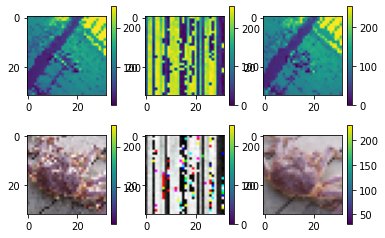

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.26it/s]

Packing None
Packing <ReluBackward0 object at 0x000001B1CC919250>
Packing <ViewBackward0 object at 0x000001B1CC94EBE0>
Packing <TBackward0 object at 0x000001B1CC94EBE0>
Packing <AddBackward0 object at 0x000001B1CC949D30>
Packing None
Unpacking <AddBackward0 object at 0x000001B1CC9153D0>
Unpacking None
Unpacking <ViewBackward0 object at 0x000001B1CC949D30>
Unpacking <TBackward0 object at 0x000001B1CC9153D0>
Unpacking <ReluBackward0 object at 0x000001B1CC919250>
Unpacking None


In [6]:
def pack_hook(x):
    print("Packing", x.grad_fn)
    return x

def unpack_hook(x):
    print("Unpacking", x.grad_fn)
    return x

loss_tot = torch.zeros(nb_epochs)
loss_valid = torch.zeros(nb_epochs)
print(loss_tot)
for e in tqdm(range(nb_epochs)):
    model.train()
    for i in range(len(input)):
        with torch.autograd.graph.saved_tensors_hooks(pack_hook, unpack_hook):
            output = model(input[i])
            loss = mse(output, target[i])
            loss_tot[e] += loss.item()    
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
        optimizer.step()
    
    model.eval()
    valid_output = model(valid_inp)
    loss_valid[e] = mse(valid_output, valid_target).item()

    if torch.remainder(torch.tensor(e), 100)==0:
        plt.figure()
        im = 0
        im2 = 0
        plt.subplot(2, 3, 1)
        plt.imshow(transform(input[i][im]))
        plt.colorbar()
        plt.subplot(2, 3, 2)
        plt.imshow(transform(output[im]))
        plt.colorbar()
        plt.subplot(2, 3, 3)
        plt.imshow(transform(target[i][im]))
        plt.colorbar()
        plt.subplot(2, 3, 4)
        plt.imshow(transform(valid_inp[im2]))
        plt.colorbar()
        plt.subplot(2, 3, 5)
        plt.imshow(transform(valid_output[im2]))
        plt.colorbar()
        plt.subplot(2, 3, 6)
        plt.imshow(transform(valid_target[im2]))
        plt.colorbar()
        plt.show()

In [7]:
loss.grad_fn


In [8]:
a = torch.ones(5, requires_grad=True) 
b = torch.ones(5, requires_grad=True) * 2
with torch.autograd.graph.saved_tensors_hooks(pack_hook, unpack_hook):
    y = a * b

y.sum().backward()
for param in model.parameters():
    print(param.grad)

Packing None
Packing <MulBackward0 object at 0x000001B1E3975760>
Unpacking None
Unpacking <MulBackward0 object at 0x000001B1E3975C70>
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0044, 0.0044, 0.0046,  ..., 0.0087, 0.0081, 0.0090],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0006, 0.0007, 0.0007,  ..., 0.0012, 0.0010, 0.0012],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
tensor([ 0.0000e+00,  1.3241e-02,  0.0000e+00,  0.0000e+00,  3.1861e-03,
        -3.0852e-03,  0.0000e+00,  3.3114e-03,  1.5573e-03, -1.6904e-03,
         0.0000e+00,  5.6646e-03,  3.0912e-03, -4.4719e-03,  0.0000e+00,
         5.9438e-03,  1.8985e-02, -1.2955e-03,  0.0000e+00, -3.0388e-03,
         0.0000e+00,  0.0000e+00, -3.9898e-03,  0.0000e+00,  3.1689e-04,
        -2.8103e-03,  1.3451e-02, -4.1667e-04,  0.0000e+00, -1.0143e-02,
      

In [9]:
for param in model.parameters():
    print(param)
    print(param.grad)

Parameter containing:
tensor([[ 0.0805,  0.0642, -0.1738,  ..., -0.1554, -0.0958, -0.0503],
        [ 0.1625, -0.1347,  0.0602,  ..., -0.1241,  0.1483, -0.1581],
        [ 0.1210,  0.0266,  0.0425,  ..., -0.0077, -0.1728,  0.0239],
        ...,
        [-0.1269,  0.1028,  0.1379,  ..., -0.1642, -0.1122, -0.0978],
        [-0.0598,  0.0545,  0.1630,  ..., -0.1230,  0.1752,  0.0295],
        [-0.1202,  0.0528, -0.0055,  ...,  0.0732, -0.1020, -0.1505]],
       device='cuda:0', requires_grad=True)
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0044, 0.0044, 0.0046,  ..., 0.0087, 0.0081, 0.0090],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0006, 0.0007, 0.0007,  ..., 0.0012, 0.0010, 0.0012],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
Parameter containing:
tensor([-0.1597,  0.0986, -0.1719,  0.1464,  0.0865, -0.

In [189]:
from torch import empty , cat , arange
from torch.nn.functional import fold , unfold

class relu(object) :
    def __init__(self):
        pass
    def forward(self, input) :
        self.input = input
        self.positif_mask = (input > 0)
        return self.positif_mask*(input)
    def backward(self, gradwrtoutput) :
        self.input.grad = self.positif_mask.int()*gradwrtoutput
        return self.input.grad
    def param(self) :
        return []

class sigmoid(object) :
    def forward(self, input) :
        self.input = input
        self.output = 1/(1 + math.e**(-input))
        return  self.output
    def backward(self, gradwrtoutput ) :
        self.input.grad = self.output * (1-self.output) * gradwrtoutput
        return self.input.grad
    def param(self) :
        return []
    
class convolution(object):
    def __init__(self, in_ch, out_ch, kernel_size = (3,3), padding = 0, stride = 1, use_bias = False):
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.kernel_size = kernel_size
        self.k = self.kernel_size[0]
        self.use_bias = use_bias
        self.stride = stride
        self.padding = padding
        self.kernel = torch.empty(out_ch, in_ch, self.k, self.k).normal_()
        self.bias = torch.empty(out_ch).normal_() if use_bias else torch.zeros(out_ch)
        
    def forward(self, x):   
        
        self.batch_size = x.size(0)
        self.s_in = x.size(-1)
        self.s_out = torch.tensor(x.size(-2)-self.k+1+self.padding*2).div(self.stride).ceil().int()
        
        X_unf = unfold(x, kernel_size=(self.k, self.k), padding = self.padding, stride = self.stride)
        
        self.x = x
        self.X_unf = X_unf
    
        K_expand = self.kernel.view(self.out_ch, -1)
        O_expand = K_expand @ X_unf

        
        O = O_expand.view(self.batch_size, self.out_ch, self.s_out, self.s_out)
        return O + self.bias.view(1, -1, 1, 1) if self.use_bias else O
    
    def backward(self, gradwrtoutput):
        dL_dO = gradwrtoutput                                       # (B x OUT_CH x SO x SO)
        dO_dX = self.kernel                                         # (OUT_CH x IN_CH x SI x SI)

        dL_dO_exp = dL_dO.reshape(self.batch_size, self.out_ch, -1) # (B x OUT_CH x (SO x SO))
        dO_dX_exp = dO_dX.reshape(self.out_ch,-1).transpose(0,1)    # (OUT_CH x (IN_CH x SI x SI))
        dL_dO_unf = dO_dX_exp @ dL_dO_exp                           # (B x (IN_CH x SI x SI) x (SO x SO))

        dL_dX = fold(dL_dO_unf, kernel_size = (self.k, self.k), padding = self.padding, stride = self.stride, output_size = (self.s_in, self.s_in))
        
        # backward wrt weights
        dL_dO_exp = dL_dO.transpose(0,1).reshape(self.out_ch, -1) # (OUT_CH x (B x SO x SO))
        dO_dF_exp = self.X_unf.transpose(-1, -2).reshape(self.batch_size*self.s_out*self.s_out, -1) # ((B x SO x SO) x (IN_CH x K x K))
        dL_dF_exp = dL_dO_exp @ dO_dF_exp # (OUT_CH x  (IN_CH x K x K))
        
        self.dL_dF = dL_dF_exp.view(self.out_ch, self.in_ch, self.k, self.k)
        
        # backward wrt bias
        if self.use_bias:
            dO_dB_exp = torch.ones(self.batch_size * (self.s_out) * (self.s_out))
            self.dL_dB = dL_dO_exp @ dO_dB_exp
        else:
            self.dL_dB = None
        
        return dL_dX, self.dL_dF, self.dL_dB

        
    def param(self) :
        return ((self.kernel, self.dL_dF), (self.bias, self.dL_dB))
    
class mse(object):
    def forward(self, input, target):
        self.input = input
        self.target = target
        return (input - target).pow(2).mean()
    def backward(self, gradwrtoutput):
        self.input.grad = 2*(self.input-self.target)/(self.input.size(-3)*self.input.size(-2)*self.input.size(-1))
    
class transposed_convolution(object):
    def __init__(self, in_ch, out_ch, kernel_size = (3,3), padding = 0, stride = 1, use_bias = False):
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.kernel_size = kernel_size
        self.k_1 = self.kernel_size[0]
        self.k_2 = self.kernel_size[1]
        self.use_bias = use_bias
        self.stride = stride
        self.padding = padding
        self.kernel = torch.empty(in_ch, out_ch, self.k_1, self.k_2).normal_()
        self.bias = torch.empty(out_ch).normal_() if use_bias else torch.zeros(out_ch)
    def forward(self, x):
        self.x = x
        self.batch_size = x.size(0)
        self.s1 = self.x.size(-2)
        self.s2 = self.x.size(-1)
        o1 = (self.s1 - 1)*self.stride + 1 + self.k_1 - 1 - self.padding *2
        o2 = (self.s2 - 1)*self.stride + 1 + self.k_2 - 1 - self.padding *2
        
        self.o1 = o1
        self.o2 = o2
        
        x_exp = x.reshape(self.batch_size, self.in_ch, -1)
        K_exp = self.kernel.reshape(self.in_ch,-1).transpose(0,1)
        O_unf = K_exp @ x_exp
        print('O_unf', O_unf.shape)
        out = fold(O_unf, kernel_size = (self.k_1, self.k_2), padding = self.padding, stride = self.stride, output_size = (o1,o2))
        
        return out + self.bias.view(1, -1, 1, 1) if self.use_bias else out
    def backward(self, gradwrtoutput):
        dL_dO = gradwrtoutput      # B x OUT_CH x SO x SO
        dO_dX = self.kernel
        
        dL_dO_unf = unfold(dL_dO, kernel_size = (self.k_1, self.k_2), padding = self.padding, stride = self.stride)
                                   # B x (OUT_CH x K x K) x SI x SI
        dO_dX_exp = dO_dX.view(self.in_ch, -1)
        dL_dX_exp = dO_dX_exp @ dL_dO_unf
        self.dL_dX = dL_dX_exp.view(self.batch_size, self.in_ch, self.s1, self.s2)
        
        self.dL_dO_unf_K = dL_dO_unf.transpose(0,1).reshape(self.out_ch * self.k_1 * self.k_2, -1).transpose(0,1)
                                                                    # (B x SI x SI) x (OUT_CH x K x K)
        self.dO_dF_exp = self.x.transpose(0,1).reshape(self.in_ch, -1)   # IN_CH x (B x SI x SI)
        self.dL_dF_exp = self.dO_dF_exp @ self.dL_dO_unf_K                         # IN_CH x (OUT_CH x K x K)                                                                       
        self.dL_dF = self.dL_dF_exp.view(self.in_ch, self.out_ch, self.k_1, self.k_2)  # OUT_CH x IN_CH x K x K
        
        dL_dO_exp = dL_dO.transpose(0,1).reshape(self.out_ch, -1)
        dO_dB_exp = torch.ones(self.batch_size * (self.o1) * (self.o2))
        self.dL_dB = dL_dO_exp @ dO_dB_exp
        
        return self.dL_dX, self.dL_dF, self.dL_dB
    


In [193]:
padding = 2
stride = 1
in_ch = 3
out_ch = 2
batch_size = 5
si = 5

test = transposed_convolution(in_ch,out_ch, kernel_size = (3,3), use_bias = True, padding = padding, stride = stride)
kernel_test = empty((in_ch,out_ch,3,3)).normal_() #torch.ones((1,1,3,3))
bias_test = empty((out_ch)).normal_()
test.kernel = kernel_test
test.bias = bias_test
kernel_comp = kernel_test.detach().requires_grad_(True)
bias_comp = bias_test.detach().requires_grad_(True)
input = empty((batch_size,in_ch,si,si)).normal_() #torch.ones((1,1,5,5))
input_comp = input.detach().requires_grad_(True)
output = test.forward(input)

valid = nn.functional.conv_transpose2d(input_comp, kernel_comp, bias = bias_comp, padding = padding, stride = stride)
print('Difference in forward is',(valid-output).abs().sum().item())

valid.backward(valid/valid)

dL_dX, dL_dF, dL_dB = test.backward(output/output)

print('Difference in backward is',(dL_dX-input_comp.grad).abs().sum().item())
print('Difference in kernel grad is',(dL_dF-kernel_comp.grad).abs().sum().item())
print('Difference in bias grad is',(dL_dB-bias_comp.grad).abs().sum().item())

O_unf torch.Size([5, 18, 25])
Difference in forward is 1.6987323760986328e-06
Difference in backward is 0.0
Difference in kernel grad is 3.4928321838378906e-05
Difference in bias grad is 0.0


In [162]:
bs = 2
ch_in, ch_out = 3, 2
s1, s2 = 3, 3
k1, k2 = 2, 2
padding = 1
input_pad = k1-1
kernel_pad = padding
stride = 2

o1, o2 = (s1 - 1)*stride + 1 + k1 -1 - padding *2 , (s2 -1)*stride +1  + k2 - 1 - padding*2
# print(o1, o2)
input = torch.empty(bs, ch_in, s1, s2).normal_()
input_comp = input.clone()
inp = input.clone()
inp.requires_grad_()
input_comp.requires_grad_()
kernel = torch.empty(ch_in, ch_out, k1, k2).normal_()
kernel_comp = kernel.clone()
kernel_comp.requires_grad_()
ker = kernel.clone()
out_comp = torch.nn.functional.conv_transpose2d(input_comp, kernel_comp, stride = stride, padding = padding)


# print(out_comp)
# print(out_comp.size())
# print(input.size())
N = (s1-1) * stride + 1
M = torch.eye(N)[range(0,N,stride)]
# print('befoinput.size())
input = M.transpose(0,1) @ input @ M
# print(input)
input = torch.nn.functional.pad(input, (input_pad,input_pad, input_pad, input_pad))
# print(input)
kernel = torch.nn.functional.pad(kernel, (kernel_pad, kernel_pad, kernel_pad, kernel_pad))
# print('ks: ',kernel.size())
input_unf = unfold(input, kernel_size = (k1 + kernel_pad *2, k2 + kernel_pad *2), padding = 0, stride = 1)

# print(input_unf.size())
kernel_exp = kernel.flip(-1, -2).transpose(0,1).reshape(ch_out, -1)

out = kernel_exp @ input_unf
print((out.view(bs, ch_out, o1, o2) - out_comp).abs().sum())

print (out_comp)
out_comp.backward(out_comp/out_comp)

tensor(5.3644e-07, grad_fn=<SumBackward0>)
tensor([[[[-1.8547,  2.1456, -0.8450, -1.2358],
          [-0.1289,  1.4646,  0.4384, -0.7649],
          [-0.0158, -1.3895,  0.8622,  1.3245],
          [-1.0327, -0.0712, -0.6475, -0.8339]],

         [[-1.2618,  2.7014, -0.2908,  1.7406],
          [-0.1069,  1.8757,  1.0132, -1.3490],
          [-0.3948, -2.2446,  1.0794,  2.3536],
          [ 1.6498, -0.9985,  1.0732, -0.6223]]],


        [[[ 2.3130, -2.5698,  1.0737,  3.3372],
          [-0.3753,  0.8586,  0.1520, -1.2269],
          [ 0.0325, -0.4415,  0.5280, -0.0055],
          [ 0.2152, -2.1576, -0.9185,  0.8249]],

         [[-0.3159, -2.9203,  0.2036,  2.7971],
          [-0.2294,  1.0180,  0.5956, -1.3995],
          [-0.9988, -0.8539,  0.8615,  0.5871],
          [-1.1035, -3.0758, -1.2219,  0.4443]]]],
       grad_fn=<ConvolutionBackward0>)


In [59]:
dL_dO = out_comp/out_comp
dO_dX = ker # kernel de base

dL_dO_unf = unfold(dL_dO, kernel_size = (k1, k2), padding = padding, stride = stride)
dO_dX_exp = dO_dX.view(ch_in, -1)
dL_dX_exp = dO_dX_exp @ dL_dO_unf
dL_dX = dL_dX_exp.view(bs, ch_in, s1, s2)


print((dL_dX - input_comp.grad).abs().sum())

tensor(0., grad_fn=<SumBackward0>)


In [60]:
print('kernel_grad\n',kernel_comp.grad)

dL_dO = out_comp/out_comp
dO_dK = inp
dL_dO_unf = unfold(dL_dO, kernel_size=(s1,s2), padding = padding, stride = stride)
dO_dK_exp = dO_dK.view(ch_in, bs, s1, s2).transpose(0,1).reshape(ch_in, -1)
dL_dK = (dO_dK_exp @ dL_dO_unf).transpose(0,1)
print('dL_dK\n',dL_dK)

kernel_grad
 tensor([[[[ 2.5337, -1.1814],
          [ 5.5879, -1.1654]],

         [[ 2.5337, -1.1814],
          [ 5.5879, -1.1654]]],


        [[[ 1.8600,  0.7618],
          [ 2.2348, -0.4778]],

         [[ 1.8600,  0.7618],
          [ 2.2348, -0.4778]]],


        [[[-0.1722,  4.8535],
          [ 0.4133,  3.2321]],

         [[-0.1722,  4.8535],
          [ 0.4133,  3.2321]]]])
dL_dK
 tensor([[[ 4.4794,  6.0261,  6.1134,  7.2105],
         [ 4.4794,  6.0261,  6.1134,  7.2105]],

        [[ 1.8600,  3.2338,  3.3613,  4.1637],
         [ 1.8600,  3.2338,  3.3613,  4.1637]],

        [[-2.1178, -3.8349, -1.7256, -5.1437],
         [-2.1178, -3.8349, -1.7256, -5.1437]]], grad_fn=<TransposeBackward0>)


In [47]:
print(test.bias)

tensor([-0.9374])


In [48]:
im = torch.empty((1,1,4,4)).normal_()
input_pad = 2

s_1 = im.size(-2)
s_2 = im.size(-1)
out = 0 * empty((im.size(0), im.size(1), (s_1 + 2*input_pad), (s_2 + 2*input_pad)))
print(input_pad, s_1+input_pad)
out[:,:,input_pad:s_1+input_pad,input_pad:s_1+input_pad] = im
print(out)        

2 6
tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000],
          [ 0.0000,  0.0000,  0.7654, -1.6992, -0.0919,  1.0053,  0.0000,
            0.0000],
          [ 0.0000,  0.0000, -1.6727,  0.7455,  1.1585,  0.7923,  0.0000,
            0.0000],
          [ 0.0000,  0.0000, -0.4828,  1.2532, -1.4356,  0.5654,  0.0000,
            0.0000],
          [ 0.0000,  0.0000,  0.2642,  0.5496, -2.0723, -0.5393,  0.0000,
            0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000]]]])


Je vais direct en Po

In [17]:
MSE = nn.MSELoss()

target = torch.randn(1, 1, 3, 3)
print(target)

input = torch.randn(1, 1, 3, 3, requires_grad=True)
input2 = input.detach().requires_grad_(True)

print(input)
# print(input2)
model = sigmoid()
model2 = torch.nn.Sigmoid()

out = model.forward(input)
out2 = model2.forward(input2)

print(out)
print(out2)
my_mse = mse()
loss = my_mse.forward(out, target)
loss2 = MSE(out2, target)

print(loss)
print(loss2)
my_mse.backward(loss)
model.backward(my_mse.input.grad)

loss2.backward()

# print(model.input.grad)

print(input.grad)
print(input2.grad)


tensor([[[[ 0.6813, -0.5588,  0.8930],
          [ 0.8944,  1.1108,  0.9046],
          [ 0.0310, -0.0991,  1.1131]]]])
tensor([[[[ 0.4607,  0.8508,  2.0295],
          [ 1.8257,  0.0886,  0.1149],
          [-2.4982,  1.1908, -0.6979]]]], requires_grad=True)
tensor([[[[0.6132, 0.7007, 0.8839],
          [0.8613, 0.5221, 0.5287],
          [0.0760, 0.7669, 0.3323]]]], grad_fn=<MulBackward0>)
tensor([[[[0.6132, 0.7007, 0.8839],
          [0.8613, 0.5221, 0.5287],
          [0.0760, 0.7669, 0.3323]]]], grad_fn=<SigmoidBackward0>)
tensor(0.3824, grad_fn=<MeanBackward0>)
tensor(0.3824, grad_fn=<MseLossBackward0>)
tensor([[[[-0.0036,  0.0587, -0.0002],
          [-0.0009, -0.0326, -0.0208],
          [ 0.0007,  0.0344, -0.0385]]]], grad_fn=<MulBackward0>)
tensor([[[[-0.0036,  0.0587, -0.0002],
          [-0.0009, -0.0326, -0.0208],
          [ 0.0007,  0.0344, -0.0385]]]])


tensor(2150.3560, grad_fn=<MeanBackward0>)
tensor(2150.3560, grad_fn=<MseLossBackward0>)
check loss:  tensor(0., grad_fn=<MeanBackward0>)
torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32])
tensor([[[[ 101.9469,  282.1165,  287.1714,  ...,   94.2469,  -73.6684,
             38.3973],
          [ -78.8686,  218.6913, -135.7656,  ...,  201.3781,  120.6222,
            -25.6699],
          [ 147.7578, -488.2459, -532.1083,  ..., -576.7558,  -19.6818,
            123.7433],
          ...,
          [ -19.7360, -305.9786,  481.2215,  ...,  412.5696,  -60.4231,
           -197.4908],
          [  -6.4519, -135.5654,   55.2048,  ..., -124.7247,   67.0563,
             98.3516],
          [ -41.5326,   34.6708,   73.6975,  ...,  -35.8991,  -42.8475,
            -59.0836]],

         [[  18.7997,  -22.3118,    4.9849,  ...,   27.4180,  -56.4722,
             31.1526],
          [   2.3386,  174.4782, -248.7210,  ...,   68.6209, -176.0816,
           -106.2730],
          [-108.9441,  117.4871

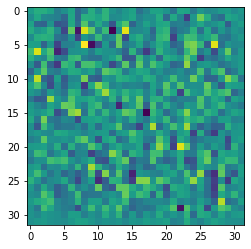

In [50]:
in_ch, out_ch = 2, 3
ker_size = (3,3)
batch_size = 1
im_size = 7

test_conv = convolution(in_ch, out_ch, kernel_size = (3,3))

dummy_input = (torch.empty((batch_size,in_ch,32,32)).normal_()*10).requires_grad_(True)
dummy_input_check = dummy_input.clone().detach().requires_grad_(True)

test_conv = convolution(in_ch, out_ch, kernel_size = ker_size)  # Our conv
kernel = test_conv.kernel

output = test_conv.forward(dummy_input)
output_check = nn.functional.conv2d(dummy_input_check, kernel)

MSE = mse()
MSE_check = torch.nn.MSELoss()

loss = MSE.forward(output, output*2)
loss_check = MSE_check(output_check, output_check*2)

torch.testing.assert_allclose(output, output_check)
print(loss)
print(loss_check)
print('check loss: ',(loss - loss_check).abs().mean())

MSE.backward(loss)


test_conv.backward(MSE.input.grad)
loss_check.backward()

test_conv.backward(output)


print(test_conv.dL_dX.size())
print(dummy_input_check.grad.size())
print(test_conv.dL_dX)
print(dummy_input_check.grad)
print((test_conv.dL_dX - dummy_input_check.grad).abs())
import matplotlib.pyplot as plt
plt.imshow((test_conv.dL_dX - dummy_input_check.grad)[0][0].detach())

In [ ]:
in_ch, out_ch = 2, 3
ker_size = (3,3)
batch_size = 50
im_size = 7



dummy_input = (torch.empty((batch_size,in_ch,im_size,im_size)).normal_()*10).requires_grad_(True)

test_conv = convolution(in_ch, out_ch, kernel_size = ker_size)  # Our conv
kernel = test_conv.kernel
print('kernel.size: ', kernel.size())
torch_out = nn.functional.conv2d(dummy_input, kernel)   # THE Conv

test_out = test_conv.forward(dummy_input)
torch.testing.assert_allclose(test_out, torch_out)

# loss = torch.rand(test_out.size())

print('loss size: ', loss.size())
back_padding = (2, 2)
unf = unfold(loss, kernel_size = ker_size, padding = back_padding)
print('unf size: ', unf.size())
kernel_back = kernel.transpose(0,1).flip(-2,-1)
print(kernel_back.size(), unf.size())
print('kernel_back: ', kernel_back.reshape(in_ch, -1).size())
out = kernel_back.reshape(in_ch, -1) @ unf
print(out.view(batch_size,in_ch, im_size, im_size).size())

# torch.testing.assert_allclose(test_out, out.view(batch_size,in_ch, im_size, im_size))


In [ ]:
dummy_input = (torch.empty((10,2,7,7)).normal_()*10).view(20,1,7,7)
print(unfold(dummy_input, kernel_size = (3,3)).size())


In [ ]:
inp = torch.normal(torch.zeros(5), torch.ones(5)*2)
print('input: ', inp)
tar = torch.round(inp).requires_grad_(True)
model= relu()
model_comp = torch.nn.ReLU()
inp
inp.requires_grad_(True)
inp_comp = inp.clone()
out = model.forward(inp)
out_comp = model_comp(inp)
print('output: ', out)
print('output_comp: ', out_comp)

mse_comp = torch.nn.MSELoss()
loss = mse(out,tar)
loss_comp = mse_comp(out_comp,tar)
print('loss: ', loss)
print('loss_comp: ', loss_comp)


print(model.backward(loss))
loss_comp.backward()
print(inp_comp.grad)
print(out_comp.grad)
# torch.autograd.grad(out)


In [ ]:
out2.grad

In [ ]:
import matplotlib.pyplot as plt
plt.plot(inp,out, '.')
plt.plot(inp,tar, '.')
plt.plot(inp, loss, '.')

In [ ]:
(a > 0).int()

In [ ]:
class old_convolution(object):
    def __init__(self, in_ch, out_ch, kernel_size = (3,3), padding = 0, stride = 1, use_bias = False):
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.kernel_size = kernel_size
        self.k_1 = self.kernel_size[0]
        self.k_2 = self.kernel_size[1]
        self.use_bias = use_bias
        self.stride = stride
        self.padding = padding
        self.kernel = empty(out_ch, in_ch, self.k_1, self.k_2).normal_()
        self.bias = empty(out_ch).normal_() if use_bias else 0 *empty(out_ch)
        
    def forward(self, x):   
        self.x = x
        self.batch_size = x.size(0)
        X_unf = unfold(x, kernel_size=(self.k_1, self.k_2), padding = self.padding, stride = self.stride)
        K_expand = self.kernel.view(self.out_ch, -1)
        O_expand = K_expand @ X_unf
        s1 = math.ceil((x.size(-2)-self.k_1+1+self.padding*2)/(self.stride))
        s2 = math.ceil((x.size(-1)-self.k_2+1+self.padding*2)/(self.stride))

        O = O_expand.view(self.batch_size, self.out_ch, s1, s2)
        return O + self.bias.view(1, -1, 1, 1) if self.use_bias else O
    
    def backward(self, gradwrtoutput):
        kernel_back = self.kernel.flip(-2, -1).transpose(0,1)
        s1 = self.x.size(-2)
        s2 = self.x.size(-1)
        
        # backward wrt input
        M = self.get_M(s1-self.k_1 + 1 + self.padding*2)
        dL_dO = (M.transpose(0,1) @ gradwrtoutput) @ M

        dL_dO_unf = unfold(dL_dO, kernel_size=(self.k_1, self.k_2), padding = (self.k_1 - 1 - self.padding, self.k_2-1- self.padding), stride = 1)
        dO_dX_exp = kernel_back.reshape(self.in_ch, -1)
        dL_dX_exp = dO_dX_exp @ dL_dO_unf
        dL_dX = dL_dX_exp.view(self.batch_size, self.in_ch, s1, s2)
        
        self.dL_dO = dL_dO.transpose(0,1) # K
        self.dO_dF = self.x.view(self.in_ch, self.batch_size, s1, s2).transpose(0,1) # X
        
        # backward wrt weights
        dL_dO_unf_F = self.dL_dO.reshape(self.out_ch, -1)
        dO_dF_exp = unfold(self.dO_dF, kernel_size = (s1 - self.k_1 +1 + self.padding*2, s2 - self.k_2 +1 + self.padding*2), padding = self.padding, stride = 1)
        dL_dF_exp = dL_dO_unf_F @ dO_dF_exp.view(self.in_ch,-1,self.k_1*self.k_2)
        dL_dF = dL_dF_exp.transpose(0,1).view(self.kernel.size())
        
        # backward wrt bias
        if self.use_bias:
            dL_dO_exp = self.dL_dO.reshape(self.out_ch, -1)
            dO_dB_exp = torch.ones(self.batch_size * (s1 - self.k_1 +1 + self.padding*2) * (s2 - self.k_2 +1 + self.padding*2))
            dL_dB = dL_dO_exp @ dO_dB_exp
        else:
            dL_dB = None
        self.dL_dX = dL_dX
        self.dL_dF = dL_dF
        self.dL_dB = dL_dB
        return dL_dX, dL_dF, dL_dB
    
    def get_M(self, N):
        diag = empty(N)
        eye_N = (diag == diag).float().diag()
        return eye_N[range(0,N,self.stride)]
        
    def param(self) :
        return [self.kernel, self.bias]
    
class old_transposed_convolution(object):
    def __init__(self, in_ch, out_ch, kernel_size = (3,3), padding = 0, stride = 1, use_bias = False):
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.kernel_size = kernel_size
        self.k_1 = self.kernel_size[0]
        self.k_2 = self.kernel_size[1]
        self.use_bias = use_bias
        self.stride = stride
        self.padding = padding
        self.input_pad_1 = self.k_1-1
        self.input_pad_2 = self.k_2-1
        self.kernel_pad = padding
        self.kernel = torch.empty(in_ch, out_ch, self.k_1, self.k_2).normal_()
        self.bias = torch.empty(out_ch).normal_() if use_bias else torch.zeros(out_ch)
    def forward(self, x):
        self.x = x
        self.batch_size = x.size(0)
        self.s1 = self.x.size(-2)
        self.s2 = self.x.size(-1)
        o1 = (self.s1 - 1)*self.stride + 1 + self.k_1 - 1 - self.padding *2
        o2 = (self.s2 - 1)*self.stride + 1 + self.k_2 - 1 - self.padding *2
        
        M = self.get_M((self.s1-1) * self.stride + 1)
        O_expand = (M.transpose(0,1) @ x) @ M
        O_padded = self.pad(O_expand, self.input_pad_1)
        K_padded = self.pad(self.kernel, self.kernel_pad)
        O_unfolded = unfold(O_padded, kernel_size = (self.k_1 + self.kernel_pad *2, self.k_2 + self.kernel_pad *2))
        kernel_back = K_padded.flip(-2, -1).transpose(0,1).reshape(self.out_ch, -1)
        O = kernel_back @ O_unfolded
        out = O.view(self.batch_size, self.out_ch, o1, o2) + self.bias.view(1, -1, 1, 1) if self.use_bias else O.view(self.batch_size, self.out_ch, o1, o2)
        return out
    def backward(self, gradwrtoutput):
        dL_dO = gradwrtoutput
        dO_dX = self.kernel
        dL_dO_unf = unfold(dL_dO, kernel_size = (self.k_1, self.k_2), padding = self.padding, stride = self.stride)
        dO_dX_exp = dO_dX.view(self.in_ch, -1)
        dL_dX_exp = dO_dX_exp @ dL_dO_unf
        self.dL_dX = dL_dX_exp.view(self.batch_size, self.in_ch, self.s1, self.s2)
        return self.dL_dX
    def get_M(self, N):
        diag = empty(N)
        eye_N = (diag == diag).float().diag()
        return eye_N[range(0,N,self.stride)]
    def pad(self, im, n_pad):
        s_1 = im.size(-2)
        s_2 = im.size(-1)
        out = 0 * empty((im.size(0), im.size(1), (s_1 + 2*n_pad), (s_2 + 2*n_pad)))
        out[:,:,n_pad:n_pad+s_1,n_pad:n_pad+s_2] = im
        return out